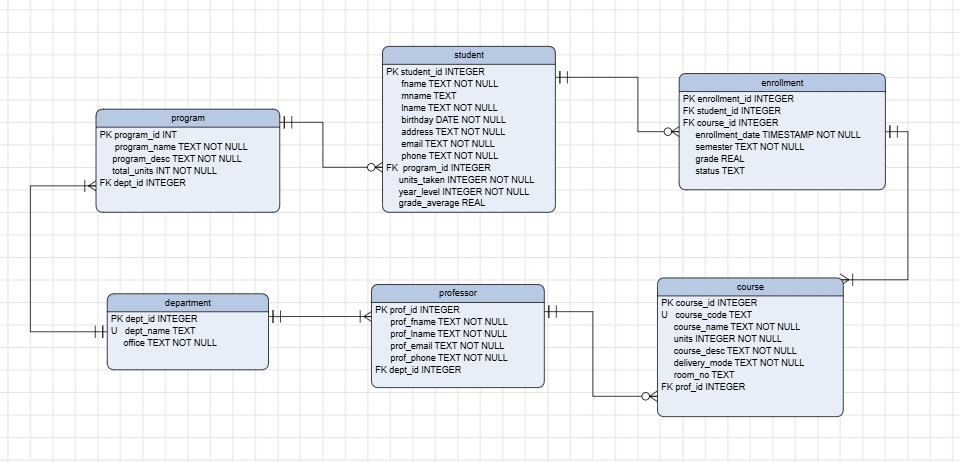

# Enrollment DB

## Methods

### Students
*   Add New Student
*   Update Student Details
*   Get Student Record - find student by id
*   Print Student Table - SELECT * FROM student
*   Enroll Student - enroll into a course
*   Drop Student - drop a course
*   Check Course History - check all subjects taken
*   Print Grades (from check grades)

### Department
*   Add New Department
*   Find Department by ID
*   Check Programs in Department
*   Print Department Table

### Program
*   Add New Program
*   Find Program by ID
*   Print Program Table

### Professor
*   Add New Professor
*   Get Professor Record
*   Print Professor Table

### Courses
*   Add New Course
*   Print Course Table
*   Find Course by ID - check description of a course by id
*   Check Students in Course
*   Assign Prof to Course
*   Add Grade for Student in Course - add grade, automatic status update depending on grade and update grade_average as well


In [ ]:
import sqlite3
import datetime

# create objects

class Department:
  def __init__(self, dept_id, dept_name, office):
    self.dept_id = dept_id
    self.dept_name = dept_name
    self.office = office

class Program:
  def __init__(self, program_id, program_name, program_desc, total_units, dept_id):
    self.program_id = program_id
    self.program_name = program_name
    self.program_desc = program_desc
    self.total_units = total_units
    self.dept_id = dept_id

class Student:
  def __init__(self, student_id, fname, mname, lname, birthday, address, email, phone, program_id, units_taken, year_level, grade_average):
    self.student_id = student_id
    self.fname = fname
    self.mname = mname
    self.lname = lname
    self.birthday = birthday
    self.address = address
    self.email = email
    self.phone = phone
    self.program_id = program_id
    self.units_taken = units_taken
    self.year_level = year_level
    self.grade_average = grade_average

class Professor:
  def __init__(self, prof_id, prof_fname, prof_lname, prof_email, prof_phone, dept_id):
    self.prof_id = prof_id
    self.prof_fname = prof_fname
    self.prof_lname = prof_lname
    self.prof_email = prof_email
    self.prof_phone = prof_phone
    self.dept_id = dept_id

class Course:
  def __init__(self, course_id, course_code, course_name, course_desc, units, delivery_mode, room_no, prof_id):
    self.course_id = course_id
    self.course_code = course_code
    self.course_name = course_name
    self.course_desc = course_desc
    self.units = units
    self.delivery_mode = delivery_mode
    self.room_no = room_no
    self.prof_id = prof_id

In [ ]:
class EnrollmentDB:
  def __init__(self, db_name):
    self.conn = sqlite3.connect(db_name)
    self.cursor = self.conn.cursor()

    # create tables

    # department table
    self.cursor.execute("""
      CREATE TABLE IF NOT EXISTS department (
        dept_id INTEGER PRIMARY KEY,
        dept_name TEXT NOT NULL UNIQUE,
        office TEXT NOT NULL
      )""")

    # program table
    self.cursor.execute("""
      CREATE TABLE IF NOT EXISTS program(
        program_id INTEGER PRIMARY KEY,
        program_name TEXT NOT NULL,
        program_desc TEXT NOT NULL,
        total_units REAL NOT NULL,
        dept_id INTEGER,
        FOREIGN KEY (dept_id) REFERENCES department(dept_id)
      )""")

    # student table
    self.cursor.execute("""
      CREATE TABLE IF NOT EXISTS student(
        student_id INTEGER PRIMARY KEY,
        fname TEXT NOT NULL,
        mname TEXT,
        lname TEXT NOT NULL,
        birthday DATE NOT NULL,
        address TEXT NOT NULL,
        email TEXT NOT NULL CHECK (email LIKE '%@%.com'),
        phone TEXT NOT NULL CHECK(length(phone) == 11),
        program_id INTEGER,
        units_taken REAL NOT NULL,
        year_level INTEGER NOT NULL,
        grade_average REAL CHECK(grade_average BETWEEN 1.0 AND 5.0),
        FOREIGN KEY (program_id) REFERENCES program(program_id)
      )""")

    # professor table
    self.cursor.execute("""
      CREATE TABLE IF NOT EXISTS professor(
        prof_id INTEGER PRIMARY KEY,
        prof_fname TEXT NOT NULL,
        prof_lname TEXT NOT NULL,
        prof_email TEXT NOT NULL CHECK(prof_email LIKE '%@%.com'),
        prof_phone TEXT NOT NULL CHECK(length(prof_phone) == 11),
        dept_id INTEGER,
        FOREIGN KEY (dept_id) REFERENCES department(dept_id)
      )""")

    # course table
    self.cursor.execute("""
      CREATE TABLE IF NOT EXISTS course(
        course_id INTEGER PRIMARY KEY,
        course_code TEXT NOT NULL UNIQUE,
        course_name TEXT NOT NULL,
        course_desc TEXT NOT NULL,
        units REAL NOT NULL,
        delivery_mode TEXT NOT NULL CHECK(delivery_mode IN ('online', 'onsite', 'hybrid')),
        room_no TEXT,
        prof_id INTEGER,
        FOREIGN KEY (prof_id) REFERENCES professor(prof_id)
      )""")

    # enrollment table
    self.cursor.execute("""
      CREATE TABLE IF NOT EXISTS enrollment(
        enrollment_id INTEGER PRIMARY KEY,
        student_id INTEGER,
        course_id INTEGER,
        enrollment_date TIMESTAMP NOT NULL,
        semester TEXT NOT NULL,
        grade REAL CHECK(grade BETWEEN 1.0 AND 5.0),
        status TEXT CHECK(status IN ('ENROLLED', 'PASS', 'FAIL', 'DROP', 'INC')),
        FOREIGN KEY (student_id) REFERENCES student(student_id),
        FOREIGN KEY (course_id) REFERENCES course(course_id)
    )""")
    self.conn.commit()

  def __del__(self):
    try:
        if self.conn:
            self.conn.close()
    except Exception as e:
        print(f"Error closing connection: {e}")

  # FOR STUDENTS
  def add_new_student(self, student):
    try:
      if not student.fname or not student.lname or not student.email or not student.phone:
            return {'error': 'Missing required fields.'}

      self.cursor.execute("""INSERT INTO student (fname, mname, lname, birthday, address, email, phone, program_id,
      units_taken, year_level, grade_average)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)""", (student.fname, student.mname, student.lname, student.birthday, student.address,
                                                      student.email, student.phone, student.program_id, student.units_taken, student.year_level,
                                                      student.grade_average))
      self.conn.commit()
      student_id = self.cursor.lastrowid
      student.student_id = student_id
      return {'message': 'Student successfully added.'}
    except Exception as e:
        return {'error': str(e)}

  def update_student(self, student_id, name, age, department_id):
    try:
      self.cursor.execute("""UPDATE students
                  SET name = ?, age = ?, department_id = ?
                  WHERE student_id = ?""", (name, age, department_id, student_id))
      self.conn.commit()
    except Exception as e:
        return {'error': str(e)}

  def get_student_record(self, student_id):
    self.cursor.execute("""SELECT * FROM student WHERE student_id = ?""", (student_id,))
    student_record = self.cursor.fetchone()
    if not student_record:
      return {'error': 'Student not found.'}
    else:
      return student_record

  def print_student_table(self):
    self.cursor.execute("""SELECT * FROM student""")
    students = self.cursor.fetchall()

    if not students:
        return {'error': 'No students found.'}

    print("Student Table:")
    print(f"{'Student ID':<12}{'First Name':<20}{'Middle Name':<20}{'Last Name':<20}{'Date of Birth':<15}{'Address':<100}{'Email':<30}{'Phone':<20}{'Program ID':<12}{'Units Taken':<12}{'Year Level':<12}{'GWA':<12}")
    print("-" * 300)

    for student in students:
        student_id, fname, mname, lname, birthday, address, email, phone, program_id, units_taken, year_level, grade_average = student

        # Replace None values with 'NULL' (I was having an error using the print pattern I used for other tables)
        mname = mname if mname is not None else 'NULL'
        program_id = program_id if program_id is not None else 'NULL'
        grade_average = grade_average if grade_average is not None else 'NULL'

        print(f"{student_id:<12}{fname:<20}{mname:<20}{lname:<20}{birthday:<15}{address:<100}{email:<30}{phone:<20}{program_id:<12}{units_taken:<12}{year_level:<12}{grade_average:<12}")


  def delete_student(self, student_id):
    try:
        self.cursor.execute("DELETE FROM student WHERE student_id = ?", (student_id,))
        self.conn.commit()
        return {'Student deleted successfully.'}
    except sqlite3.Error as e:
        return {'error': str(e)}

  def enroll_student(self, student_id, course_id, semester):
    try:
      self.cursor.execute("SELECT course_id FROM course WHERE course_id = ?", (course_id,))
      course = self.cursor.fetchone()

      if not course:
        return {"error": f"Course ID {course_id} does not exist in the database."}

      self.cursor.execute("""INSERT INTO enrollment (student_id, course_id, enrollment_date, semester, status)
        VALUES (?, ?, ?, ?, ?)""", (student_id, course_id, datetime.datetime.now(), semester, 'ENROLLED'))
      self.conn.commit()
      return {"success": f"Student ID {student_id} successfully enrolled in Course ID {course_id} for {semester}."}

    except Exception as e:
        return {"error": f"An error occurred while enrolling the student: {e}"}

  def drop_student(self, student_id, course_id):
    self.cursor.execute("""UPDATE enrollment SET status = 'DROP' WHERE student_id = ? AND course_id = ?""", (student_id, course_id))
    self.conn.commit()

  def check_current_courses(self, student_id, semester):
    self.cursor.execute("""SELECT course_id FROM enrollment WHERE student_id = ? AND status = 'ENROLLED'""", (student_id,))
    current_courses = self.cursor.fetchall()
    if not current_courses:
      return {'error': 'No courses enrolled.'}
    else:
      return current_courses

  def check_courses_history(self,student_id):
    self.cursor.execute("""
      SELECT c.course_name, c.course_code, c.units, e.semester, e.status
      FROM enrollment AS e
      INNER JOIN course AS c
      ON e.course_id = c.course_id
      WHERE student_id = ?""", (student_id,))
    courses_history = self.cursor.fetchall()
    if not courses_history:
      return {'error': 'History not available.'}
    else:
      return courses_history

  def check_grades(self, student_id):
    try:
        self.cursor.execute("""
            SELECT c.course_name, c.course_code, e.semester, e.grade
            FROM enrollment AS e
            INNER JOIN course AS c
            ON e.course_id = c.course_id
            WHERE e.student_id = ? AND e.status != 'DROP'
        """, (student_id,))
        grades = self.cursor.fetchall()

        if not grades:
            return None

        self.cursor.execute("""
            SELECT grade_average
            FROM student
            WHERE student_id = ?
        """, (student_id,))
        grade_average = self.cursor.fetchone()
        grade_average = grade_average[0] if grade_average else None

        return grades, grade_average

    except Exception as e:
        print(f"Error fetching grades: {e}")
        return None

  def print_student_grades(self, student_id):
    result = self.check_grades(student_id)

    if not result:
        print(f"No grades found for Student ID {student_id}.")
        return

    grades, grade_average = result

    print(f"\nGrades for Student ID {student_id}:\n")
    print(f"{'Course Code':<15} {'Course Name':<25} {'Semester':<25} {'Grade':<10}")
    print("-" * 80)

    for course_name, course_code, semester, grade in grades:

        # Handle None values for grade
        grade = grade if grade is not None else "NULL"

        print(f"{course_code:<15} {course_name:<25} {semester:<25} {grade:<10}")

    # Print average
    print("-" * 60)
    if grade_average is not None:
        print(f"GWA: {grade_average:.2f}")
    else:
        print("GWA: Not available")


  # FOR DEPARTMENT

  def add_new_department(self, department):
    try:
      self.cursor.execute("""INSERT INTO department (dept_id, dept_name, office)
        VALUES (?, ?, ?)""", (department.dept_id, department.dept_name, department.office))
      self.conn.commit()
      dept_id = self.cursor.lastrowid
      department.dept_id = dept_id
      return department
    except Exception as e:
        return {'error': str(e)}

  def find_department_by_id(self, dept_id):
    self.cursor.execute("""SELECT * FROM department WHERE dept_id = ?""", (dept_id,))
    department = self.cursor.fetchone()
    if not department:
      return {'error': 'Department not found.'}
    else:
      return department

  def check_department_programs(self, dept_id):
    self.cursor.execute("""SELECT * FROM program WHERE dept_id = ?""", (dept_id,))
    programs = self.cursor.fetchall()
    if not programs:
      return {'error': 'No programs found.'}
    else:
      return programs

  def print_department_table(self):
    self.cursor.execute("SELECT * FROM department")
    departments = self.cursor.fetchall()

    if not departments:
        print("The department table is empty.")
    else:
        print(f"{'Dept ID':<10} {'Dept Name':<20} {'Office':<15}")
        print("-" * 45)
        for dept in departments:
            print(f"{dept[0]:<10} {dept[1]:<20} {dept[2]:<15}")


  # FOR PROGRAMS

  def add_new_program(self, program):
    try:
      # Making sure dept_id is in database
      self.cursor.execute("SELECT dept_id FROM department WHERE dept_id = ?", (program.dept_id,))
      dept_exists = self.cursor.fetchone()

      if not dept_exists:
        return {'error': 'Department ID does not exist.'}

      self.cursor.execute("""INSERT INTO program (program_name, program_desc, total_units, dept_id)
        VALUES (?, ?, ?, ?)""", (program.program_name, program.program_desc, program.total_units, program.dept_id))
      self.conn.commit()
      return program
    except Exception as e:
        return {'error': str(e)}

  def find_program_by_id(self, program_id):
    self.cursor.execute("""SELECT * FROM program WHERE program_id = ?""", (program_id,))
    program = self.cursor.fetchone()
    if not program:
      return {'error': 'Program not found.'}
    else:
      return program

  def print_program_table(self):
    self.cursor.execute("SELECT * FROM program")
    programs = self.cursor.fetchall()

    print("Program Table:")
    print(f"{'Program ID':<12}{'Program Name':<30}{'Description':<100}{'Total Credits':<15}{'Dept ID':<10}")
    print("-" * 120)
    for program in programs:
      print(f"{program[0]:<12}{program[1]:<30}{program[2]:<100}{program[3]:<15}{program[4]:<10}")

  # FOR TEACHERS

  def add_new_professor(self, professor):
    try:
      # Check if dept_id exists in the department table
      self.cursor.execute("SELECT dept_id FROM department WHERE dept_id = ?", (professor.dept_id,))
      dept_exists = self.cursor.fetchone()

      if not dept_exists:
          print('error: Department ID does not exist.')
          return {'error': 'Department ID does not exist.'}

      self.cursor.execute("""INSERT INTO professor (prof_fname, prof_lname, prof_email, prof_phone, dept_id)
          VALUES (?, ?, ?, ?, ?)""",
          (professor.prof_fname, professor.prof_lname, professor.prof_email, professor.prof_phone, professor.dept_id))

      self.conn.commit()
      prof_id = self.cursor.lastrowid
      professor.prof_id = prof_id
      return professor

    except Exception as e:
        print(f"Error adding professor: {str(e)}")
        return {'error': str(e)}

  def get_professor_record(self, prof_id):
    self.cursor.execute("""SELECT * FROM professor WHERE prof_id = ?""", (prof_id,))
    prof_record = self.cursor.fetchone()
    if not prof_record:
      return {'error': 'Professor not found.'}
    else:
      return prof_record

  def print_professor_table(self):
    self.cursor.execute("""SELECT * FROM professor""")
    professors = self.cursor.fetchall()

    if not professors:
      return {'error': 'No professors found.'}

    print("\nList of Professors:\n")
    print(f"{'Professor ID':<15} {'First Name':<20} {'Last Name':<20} {'Email':<30} {'Phone':<15} {'Department ID'}")
    print("-" * 115)

    for professor in professors:
        print(f"{professor[0]:<15} {professor[1]:<20} {professor[2]:<20} {professor[3]:<30} {professor[4]:<15} {professor[5]}")


  # FOR COURSES

  def add_new_course(self, course):
    try:
      # Making sure prof_id is in database
      self.cursor.execute("SELECT prof_id FROM professor WHERE prof_id = ?", (course.prof_id,))
      prof_exists = self.cursor.fetchone()

      if not prof_exists:
          print(f"Warning: Professor ID {course.prof_id} does not exist. Setting prof_id to NULL.")
          course.prof_id = None

      self.cursor.execute("""INSERT INTO course (course_code, course_name, course_desc, units, delivery_mode, room_no, prof_id)
          VALUES (?, ?, ?, ?, ?, ?, ?)""", (course.course_code, course.course_name, course.course_desc, course.units,
                                              course.delivery_mode, course.room_no, course.prof_id))
      self.conn.commit()
      course_id = self.cursor.lastrowid
      course.course_id = course_id
      return {'message':'course successfully added'}

    except Exception as e:
        return {'error': str(e)}

  def print_course_table(self):
    self.cursor.execute("""SELECT * FROM course""")
    courses = self.cursor.fetchall()

    if not courses:
      return {'error': 'No courses found.'}

    print("Course Table:")
    print(f"{'Course ID':<12}{'Course Code':<20}{'Course Name':<30}{'Description':<100}{'Units':<10}{'Delivery Mode':<15}{'Room No':<15}{'Professor ID':<12}")
    print("-" * 140)

    for course in courses:
      course_id, course_code, course_name, course_desc, units, delivery_mode, room_no, prof_id = course

      # Replace None values with 'NULL'
      room_no = room_no if room_no is not None else 'NULL'
      prof_id = prof_id if prof_id is not None else 'NULL'

      print(f"{course_id:<12}{course_code:<20}{course_name:<30}{course_desc:<100}{units:<10}{delivery_mode:<15}{room_no:<15}{prof_id:<12}")

  def find_course_by_id(self, course_id):
    self.cursor.execute("""SELECT * FROM course WHERE course_id = ?""", (course_id,))
    course = self.cursor.fetchone()
    if not course:
      return {'error': 'Course not found.'}

    return course

  def check_students_in_course(self, course_id):
    self.cursor.execute("""SELECT c.course_id, c.course_code, c.course_name, e.semester, s.student_id,
        s.fname || ' ' || s.lname AS full_name, p.program_name, e.status
        FROM enrollment e
        INNER JOIN course c ON e.course_id = c.course_id
        INNER JOIN student s ON e.student_id = s.student_id
        INNER JOIN program p ON s.program_id = p.program_id
        WHERE course_id = ?
        ORDER BY c.course_id, e.semester, full_name
        """, (course_id,))

    students_in_course = self.cursor.fetchall()
    if not students_in_course:
      return {'error': 'No students enrolled.'}

    print(f"\nStudents enrolled in {course_id}:\n")
    print(f"{'Course Code':<15} {'Course Name':<25} {'Semester':<10} {'Student ID':<10} {'Full Name':<25} {'Program':<20} {'Status':<10}")
    print("-" * 100)

    for student in students_in_course:
      course_code, course_name, semester, student_id, full_name, program_name, status = student
      print(f"{course_code:<15} {course_name:<25} {semester:<10} {student_id:<10} {full_name:<25} {program_name:<20} {status:<10}")

  def assign_prof_to_course(self, prof_id, course_id):
    try:
      # Making sure prof_id is in database
      self.cursor.execute("SELECT prof_id FROM professor WHERE prof_id = ?", (prof_id,))
      prof_exists = self.cursor.fetchone()

      if not prof_exists:
        return {'Professor does not exist'}

      self.cursor.execute("""UPDATE course SET prof_id = ? WHERE course_id = ?""", (prof_id, course_id))
      self.conn.commit()
      return {'Professor has been assigned to course.'}

    except Exception as e:
        return {'error': str(e)}

  def add_grade_to_student(self, student_id, course_id, grade):
    try:
      status=None
      if 1.0 <= grade < 5.0:
        if grade <= 3.0:
            status = "PASS"
        elif grade == 5.0:
            status = "FAIL"
        else:
            status = "INC"
      else:
          print("Invalid grade. Please enter a grade between 1.0 and 5.0.")

      if status:
          self.cursor.execute("""
              UPDATE enrollment
              SET grade = ?, status = ?
              WHERE student_id = ? AND course_id = ?
          """, (grade, status, student_id, course_id))
          self.conn.commit()
      else:
          print("Invalid grade. No changes were made.")
          return {'error': 'Invalid grade value.'}

      # Update grades as well
      self.cursor.execute("""
          SELECT AVG(grade)
          FROM enrollment
          WHERE student_id = ? AND grade > 0
      """, (student_id,))
      new_avg = self.cursor.fetchone()[0]

      if new_avg is not None:
          self.cursor.execute("""
              UPDATE student
              SET grade_average = ?
              WHERE student_id = ?
          """, (round(new_avg, 2), student_id))
          self.conn.commit()

      return {'message': 'Grade and status updated. Grade average recalculated.'}
    except sqlite3.Error as e:
        return {'error': str(e)}

  def print_enrollment_table(self):
    self.cursor.execute("""SELECT * FROM enrollment""")
    enrollments = self.cursor.fetchall()

    if not enrollments:
        print({'error': 'No enrollment records found.'})
        return

    print("Enrollment Table:")
    print(f"{'Enrollment ID':<15}{'Student ID':<12}{'Course ID':<12}{'Enrollment Date':<40}{'Semester':<25}{'Grade':<10}{'Status':<10}")
    print("-" * 90)

    for enrollment in enrollments:
        enrollment_id, student_id, course_id, enrollment_date, semester, grade, status = enrollment

        # NULL value handling
        grade = grade if grade is not None else 'NULL'
        status = status if status is not None else 'NULL'

        print(f"{enrollment_id:<15}{student_id:<12}{course_id:<12}{enrollment_date:<40}{semester:<25}{grade:<10}{status:<10}")


# Testing

In [ ]:
enrollmentdb = EnrollmentDB('enrollment_db')

# Creating New Departments

dept1 = Department(None, 'Department of Computer Science', '1211')
dept2 = Department(None, 'Department of Lingustics', '1414')

enrollmentdb.add_new_department(dept1)
enrollmentdb.add_new_department(dept2)


In [ ]:
# trying to add the same department
enrollmentdb.add_new_department(dept1)

{'error': 'UNIQUE constraint failed: department.dept_id'}

In [ ]:
enrollmentdb.print_department_table()

Dept ID    Dept Name            Office         
---------------------------------------------
1          Department of Computer Science 1211           
2          Department of Lingustics 1414           


In [ ]:
# Add Program

prog1 = Program(None, 'BS Computer Science', '4-year undergraduate degree for computer science', 148, 1)
prog2 = Program(None, 'BS Cybersecurity', '4-year undergraduate degree specializing in Cybersecurity', 160, 1)
prog3 = Program(None, 'BA Linguistics Plan A', '4-year undergraduate degree for linguistics with chosen cognates', 135, 2)
prog4 = Program(None, 'BA Linguistics Plan C', '4-year undergraduate degree for linguistics with either Japanese or Korean as specialization', 144, 2)

enrollmentdb.add_new_program(prog1)
enrollmentdb.add_new_program(prog2)
enrollmentdb.add_new_program(prog3)
enrollmentdb.add_new_program(prog4)

In [ ]:
enrollmentdb.print_program_table()

Program Table:
Program ID  Program Name                  Description                                                                                         Total Credits  Dept ID   
------------------------------------------------------------------------------------------------------------------------
1           BS Computer Science           4-year undergraduate degree for computer science                                                    148.0          1         
2           BS Cybersecurity              4-year undergraduate degree specializing in Cybersecurity                                           160.0          1         
3           BA Linguistics Plan A         4-year undergraduate degree for linguistics with chosen cognates                                    135.0          2         
4           BA Linguistics Plan C         4-year undergraduate degree for linguistics with either Japanese or Korean as specialization        144.0          2         


In [ ]:
enrollmentdb.find_program_by_id(2)

(2,
 'BS Cybersecurity',
 '4-year undergraduate degree specializing in Cybersecurity',
 160.0,
 1)

In [ ]:
enrollmentdb.check_department_programs(2)

[(3,
  'BA Linguistics Plan A',
  '4-year undergraduate degree for linguistics with chosen cognates',
  135.0,
  2),
 (4,
  'BA Linguistics Plan C',
  '4-year undergraduate degree for linguistics with either Japanese or Korean as specialization',
  144.0,
  2)]

In [ ]:
bday1 = datetime.date(2000, 3, 20)
bday2 = datetime.date(2000, 2, 19)

student1 = Student(None, 'Juan Miguel', 'Cruz', 'Santos', bday1, '123 ABC Street, Brgy. DEF, Makati City, Metro Manila, 1234', 'abcdefg@gmail.com', '09123456789', 2, 0, 1, None)
student2= Student(None, 'Kiara', 'Corpuz', 'De Villa', bday2, '24 Walang Tulog Street, Cramming Subdivision, Paranaque City, Metro Manila, 1001', 'yokona@gmail.com', '09281122334', 3, 30, 2, 1.5)

enrollmentdb.add_new_student(student1)
enrollmentdb.add_new_student(student2)

{'message': 'Student successfully added.'}

In [ ]:
# Error
bday3 = datetime.date(2002, 6, 10)

student3 = Student(None, 'Sleepy', None, 'Puyat', bday3, '911 Coffee Avenue, Building 1, Energy Homes, Taguig City, 1111', 'no email', '12345678910', 1, 0, 1, None)

enrollmentdb.add_new_student(student3)

{'error': "CHECK constraint failed: email LIKE '%@%.com'"}

In [ ]:
enrollmentdb.print_student_table()

Student Table:
Student ID  First Name          Middle Name         Last Name           Date of Birth  Address                                                                                             Email                         Phone               Program ID  Units Taken Year Level  GWA         
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1           Juan Miguel         Cruz                Santos              2000-03-20     123 ABC Street, Brgy. DEF, Makati City, Metro Manila, 1234                                          abcdefg@gmail.com             09123456789         2           0.0         1           NULL        
2           Kiara               Corpuz              De Villa            2000-02-19     24 Walang Tulog Street, C

In [ ]:
prof1 = Professor(None, 'Joaquin', 'Lopez', 'jlopez@abccollege.com', '01234599991', 3)
prof2 = Professor(None, 'Robert', 'Cruz', 'rcruz@abccollege.com', '012345898910', 2)
prof3 = Professor(None, 'Angel', 'Ramos', 'aramos@gmail.com.com', '01234566771', 1)

enrollmentdb.add_new_professor(prof1)
enrollmentdb.add_new_professor(prof2)
enrollmentdb.add_new_professor(prof3)

error: Department ID does not exist.
Error adding professor: CHECK constraint failed: length(prof_phone) == 11


In [ ]:
enrollmentdb.print_professor_table()


List of Professors:

Professor ID    First Name           Last Name            Email                          Phone           Department ID
-------------------------------------------------------------------------------------------------------------------
1               Angel                Ramos                aramos@gmail.com.com           01234566771     1


In [ ]:
prof1 = Professor(None, 'Joaquin', 'Lopez', 'jlopez@abccollege.com', '01234599991', 1)
prof2 = Professor(None, 'Robert', 'Cruz', 'rcruz@abccollege.com', '01234589890', 2)

enrollmentdb.add_new_professor(prof1)
enrollmentdb.add_new_professor(prof2)

In [ ]:
course1 = Course(None, 'CS001', 'Intro to Programming', 'Introduction to Programming with Python', 3, 'hybrid', '201A', 1)
course2 = Course(None, 'Lingg110', 'Intro to Linguistics', 'Introductory course for linguistics', 3, 'online', None, 3)
course3 = Course(None, 'CS001B', 'Intro to Programming', 'Introduction to Programming with Python', 3, 'onsite', '201B', None)
course4 = Course(None, 'Lingg115', 'Historical Linguistics', 'Introduction to Historical linguistics', 3, 'online', None, 3)

enrollmentdb.add_new_course(course1)
enrollmentdb.add_new_course(course2)
enrollmentdb.add_new_course(course3)
enrollmentdb.add_new_course(course4)

{'message': 'course successfully added'}

In [ ]:
enrollmentdb.print_course_table()

Course Table:
Course ID   Course Code         Course Name                   Description                                                                                         Units     Delivery Mode  Room No        Professor ID
--------------------------------------------------------------------------------------------------------------------------------------------
1           CS001               Intro to Programming          Introduction to Programming with Python                                                             3.0       hybrid         201A           1           
2           Lingg110            Intro to Linguistics          Introductory course for linguistics                                                                 3.0       online         NULL           3           
3           CS001B              Intro to Programming          Introduction to Programming with Python                                                             3.0       onsite         201B         

In [ ]:
bday3 = datetime.date(1997, 7, 7)
bday4 = datetime.date(2002, 2, 1)

student3 = Student(None, 'Miguel', 'Santos', 'Dela Cruz', bday3, '321 CBA Street, Brgy. OMG, Makati City, Metro Manila, 1111', 'sanmig@gmail.com', '09123455789', 1, 50, 4, 2.0)
student4= Student(None, 'Liza', None, 'San Juan', bday4, '21 Walang Tulog Street, Cramming Subdivision, Paranaque City, Metro Manila, 1001', 'fundmycoffee@gmail.com', '09281122334', 1, 30, 2, 1.5)

enrollmentdb.add_new_student(student3)
enrollmentdb.add_new_student(student4)

{'message': 'Student successfully added.'}

In [ ]:
enrollmentdb.print_student_table()

Student Table:
Student ID  First Name          Middle Name         Last Name           Date of Birth  Address                                                                                             Email                         Phone               Program ID  Units Taken Year Level  GWA         
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1           Juan Miguel         Cruz                Santos              2000-03-20     123 ABC Street, Brgy. DEF, Makati City, Metro Manila, 1234                                          abcdefg@gmail.com             09123456789         2           0.0         1           NULL        
2           Kiara               Corpuz              De Villa            2000-02-19     24 Walang Tulog Street, C

In [ ]:
enrollmentdb.enroll_student(2, 2, 'First Sem 2019')
enrollmentdb.enroll_student(2, 4, 'Second Sem 2019')

{'success': 'Student ID 2 successfully enrolled in Course ID 4 for Second Sem 2019.'}

In [ ]:
enrollmentdb.enroll_student(3, 1, 'Second Sem 2020')
enrollmentdb.enroll_student(2, 3, 'Second Sem, 2024')

enrollmentdb.print_enrollment_table()

Enrollment Table:
Enrollment ID  Student ID  Course ID   Enrollment Date                         Semester                 Grade     Status    
------------------------------------------------------------------------------------------
1              2           2           2024-12-14 14:37:18.450648              First Sem 2019           NULL      ENROLLED  
2              2           4           2024-12-14 14:37:18.458669              Second Sem 2019          NULL      ENROLLED  
3              3           1           2024-12-14 14:37:18.475246              Second Sem 2020          NULL      ENROLLED  
4              2           3           2024-12-14 14:37:18.482531              Second Sem, 2024         NULL      ENROLLED  


In [ ]:
enrollmentdb.drop_student(2, 3)

enrollmentdb.print_enrollment_table()

Enrollment Table:
Enrollment ID  Student ID  Course ID   Enrollment Date                         Semester                 Grade     Status    
------------------------------------------------------------------------------------------
1              2           2           2024-12-14 14:37:18.450648              First Sem 2019           NULL      ENROLLED  
2              2           4           2024-12-14 14:37:18.458669              Second Sem 2019          NULL      ENROLLED  
3              3           1           2024-12-14 14:37:18.475246              Second Sem 2020          NULL      ENROLLED  
4              2           3           2024-12-14 14:37:18.482531              Second Sem, 2024         NULL      DROP      


In [ ]:
enrollmentdb.add_grade_to_student(3, 1, 4.0)
enrollmentdb.add_grade_to_student(2, 2, 1.25)
enrollmentdb.add_grade_to_student(2, 4, 1.0)

enrollmentdb.print_enrollment_table()

Enrollment Table:
Enrollment ID  Student ID  Course ID   Enrollment Date                         Semester                 Grade     Status    
------------------------------------------------------------------------------------------
1              2           2           2024-12-14 14:37:18.450648              First Sem 2019           1.25      PASS      
2              2           4           2024-12-14 14:37:18.458669              Second Sem 2019          1.0       PASS      
3              3           1           2024-12-14 14:37:18.475246              Second Sem 2020          4.0       INC       
4              2           3           2024-12-14 14:37:18.482531              Second Sem, 2024         NULL      DROP      


In [ ]:
enrollmentdb.print_student_grades(2)


Grades for Student ID 2:

Course Code     Course Name               Semester                  Grade     
--------------------------------------------------------------------------------
Lingg110        Intro to Linguistics      First Sem 2019            1.25      
Lingg115        Historical Linguistics    Second Sem 2019           1.0       
------------------------------------------------------------
GWA: 1.12
